# Statistical Modeling using Sleep Health and Lifestyle Dataset
### STAT301 Group 13 Final Report
April 14th, 2025

**Contributors:** \
Yuki Matsushima #84356377 \
Masaya Tanaka #59477232 \
Aryan Arora #81663510 

In [11]:
library(tidyverse)
library(caret)
library(pROC)
library(boot)
library(glmnet)
install.packages("vtable")
library(vtable)

also installing the dependencies ‘svglite’, ‘kableExtra’, ‘sjlabelled’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: kableExtra


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




## Introduction 
Sleep disorders are increasingly being recognized as a significant public health issue due to their impact on general well-being, cognitive functioning, and future health. Poor sleep has been linked to a wide range of negative physical health consequences, including increased risk for cardiovascular disease, obesity, diabetes, as well as emotional health consiquences such as depression, and anxiety (Grandner, 2017). The National Center of Biotechnology Information (NCBI) suggests to take at least 7 hours of sleep to maintain a healthy lifestyle (2015). Recognition of risk factors early on is likely to ensure better health results and early intervention. 

In this study, we examine several health and lifestyle factors that can be used to predict the presence of a sleep disorder. \
We use the Sleep Health and Lifestyle Dataset comprising 374 observations and 13 variables representing sleep duration, physical activity, blood pressure, stress, BMI, etc.

Furthermore, through the development of a predictive model, we aim to identify which of these factors are most relevant in predicting the presence of a sleep disorder.

#### Our research question is: 
***"Can various health factors be used to determine whether or not someone has a sleep disorder?"*** with the focus on prediction.

Scribe: Aryan, Yuki 

## Methods 
### 1. Cleaning an Preprocessing of Data
We begin by cleaning and preprocessing the dataset. We rename variables to snake_case, Split the blood pressure column into two seperate columns: systolic and diastoclic bp, Mutate the bmi category to Underweight, Normal, Overweight, Obese and we mutate the sleep disorder variables binary where 0 is no sleep disorder and 1 representing sleeping disorder.

### 2. Model Formation
Using LASSO Logistic Regression, we identify key predictors of sleep disorder. We split the training and test data by 60% (60% is training data, 40% is testing data) and perform a 10 fold cross validation to determine optimal $\lambda$ value.

### 3. Evaluating the test set
We then evaluate the model using the test set which consists of 40% of the data. Here we generate predicted probailities using the fitted LASSO Model and evaluate performance using an ROC curve (Receiver Operating Characterisitic) and calculated the area under the curve to assess accuracy.

Scribe: Aryan

### a) Data

In [12]:
# Main developer: Yuki
# read the dataset
sleep_data <- read_csv("https://raw.githubusercontent.com/yma24ma/stat301_project/refs/heads/main/Sleep_health_and_lifestyle_dataset.csv")
head(sleep_data)

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


#### Description
The Sleep Health and Lifestyle Dataset consists of 374 observations and 13 variables related to individuals' sleep habits, physical health, and lifestyle choices. It aims to analyze the factors influencing sleep quality and overall well-being. This dataset is clarified as synthetic and created by Laksika Tharmalingam for illustrative purposes, (thus its not observational nor experimental) and can be retrieved through Kaggle. (https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset?resource=download)

Scribe: copied from Yuki's assignment 2

#### Variables 
|Variable Name|Type|Description|
|-------------|----|-----------|
|`Person ID`|Integer|An identifier for each individual.|
|`Gender`|Categorical|The gender of the person (Male/Female).|
|`Age`|Integer|The age of the person in years.|
|`Occupation`|String|The occupation or profession of the person.|
|`Sleep Duration`|Float|The number of hours the person sleeps per day.|
|`Quality of Sleep`|Integer|A subjective rating of the quality of sleep, ranging from 1 to 10.|
|`Physical Activity Level`|Integer|The number of minutes the person engages in physical activity daily.|
|`Stress Level`|Integer|A subjective rating of the stress level experienced by the person, ranging from 1 to 10.|
|`BMI Category`|Categorical|The BMI category of the person (Underweight, Normal, Overweight).|
|`Blood Pressure`|String|The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. (stored as a character)|
|`Heart Rate`|Integer|The resting heart rate of the person in beats per minute.|
|`Daily Steps`|Integer|The number of steps the person takes per day.|
|`Sleep Disorder`|Categorical|The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).|

**Pre-Selection Variables:** \
(cell copied from Yuki's assignment 2)\
`Person ID` can be dropped since they do not provide sufficient information about sleep and lifestyle information. This will be done later after splitting the data

Scribe: copied from Yuki's assignment 2

### b) Explanatory Data Analysis

In [13]:
# Main developer: Yuki
# Convert the variable names into snake_case format
colnames(sleep_data) <- gsub(" ", "_", tolower(colnames(sleep_data)))

# Split the blood_pressure variable into systolic_bp and diastolic_bp and mutate into a numerical format
sleep_data <- sleep_data |>
separate(blood_pressure, into = c("systolic_bp", "diastolic_bp")) |>
mutate(systolic_bp = as.numeric(systolic_bp),
       diastolic_bp = as.numeric(diastolic_bp))

# Mutate bmi_category into "Underweight", "Normal", "Overweight", and "Obese"
# I chose to keep "Obese" since it's recognized by the governemnt of Canada as one of the classification of BMI
sleep_data <- sleep_data |>
mutate(bmi_category = if_else(bmi_category %in% c("Normal", "Normal Weight"), "Normal", bmi_category))

head(sleep_data)

person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,systolic_bp,diastolic_bp,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140,90,85,3000,Insomnia


#### Visualization

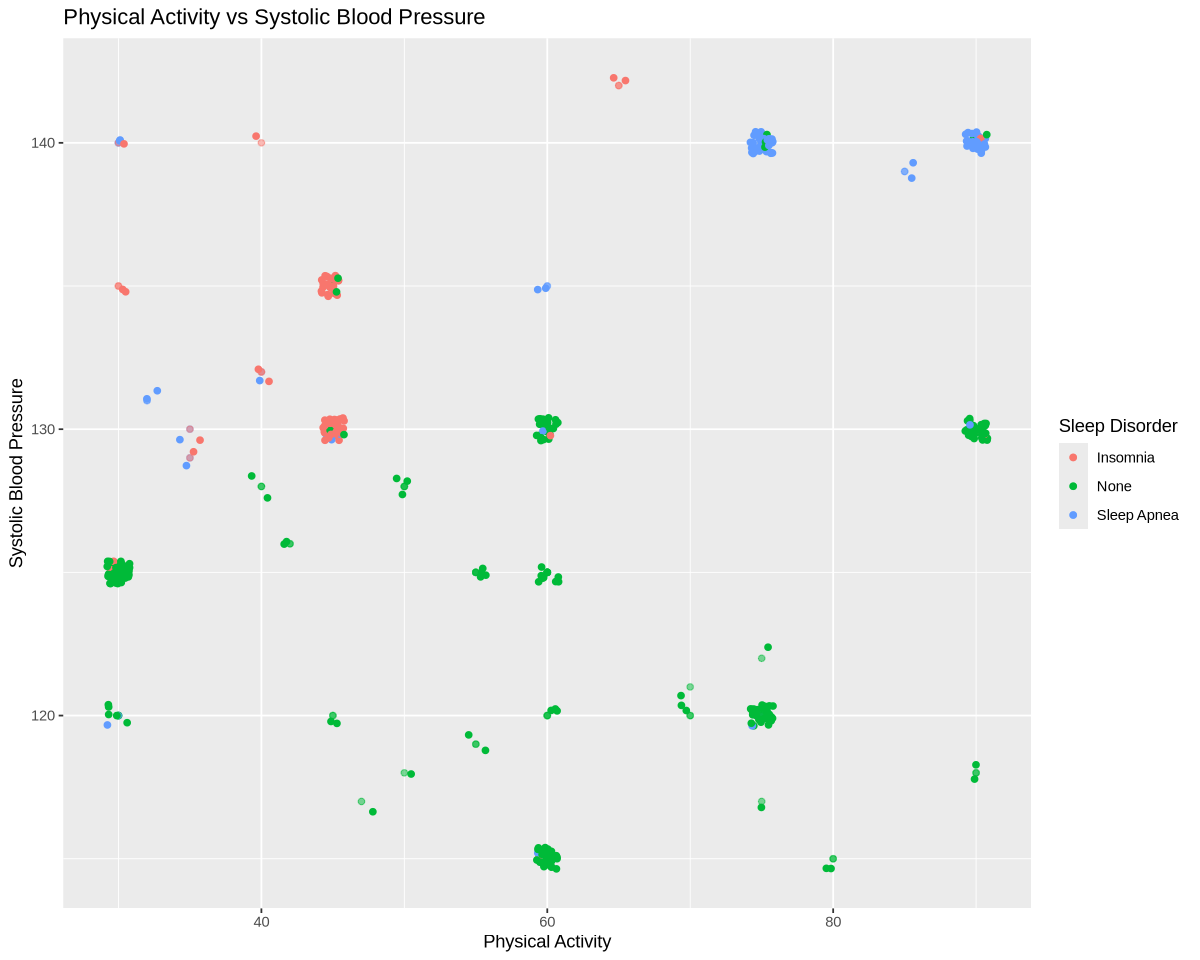

In [14]:
# Main developer: Yuki
# Scatter plot using physical activity level vs systolic blood pressure
options(repr.plot.width = 10, repr.plot.height = 8)
pa_sbp_plot <- sleep_data |>
ggplot(aes(x = physical_activity_level, y = systolic_bp, color = sleep_disorder)) +
geom_point(alpha = 0.5) +
geom_jitter() +
labs(title = "Physical Activity vs Systolic Blood Pressure", x = "Physical Activity", y = "Systolic Blood Pressure", color = "Sleep Disorder")

pa_sbp_plot

Plot. 1

**Plot.1 Interpretation:** \
This plot is relevant to addressing our research question because it visually explores the relationship between physical activity level, systolic blood pressure, and sleep disorders. Since our study aims to explore the likelihood of sleep disorders based on various health factors, this visualization helps in understanding wether physical activity and blood pressure level differ among individuals with and without sleep disorders. I chose those variables because they are key health factors that could be associated with sleep disorders and they do not involve subjective rating (such as quality_of_sleep and stress_level) and also are not rounded up or down heavily (such as daily_steps).

From Plot. 1, we can observe potential clustering patterns based on sleep disorder categories. It looks like the people with higher systolic blood pressure tends to have more sleep disorders since most of the blue and red plots are scattered on the top half of the scatter plot. \
Potential limitations would be that we have only selected two potential variables to visuallize the association against sleep disorders, which does not showcase the true effect of the variables with the predictor.

Scribe: Yuki

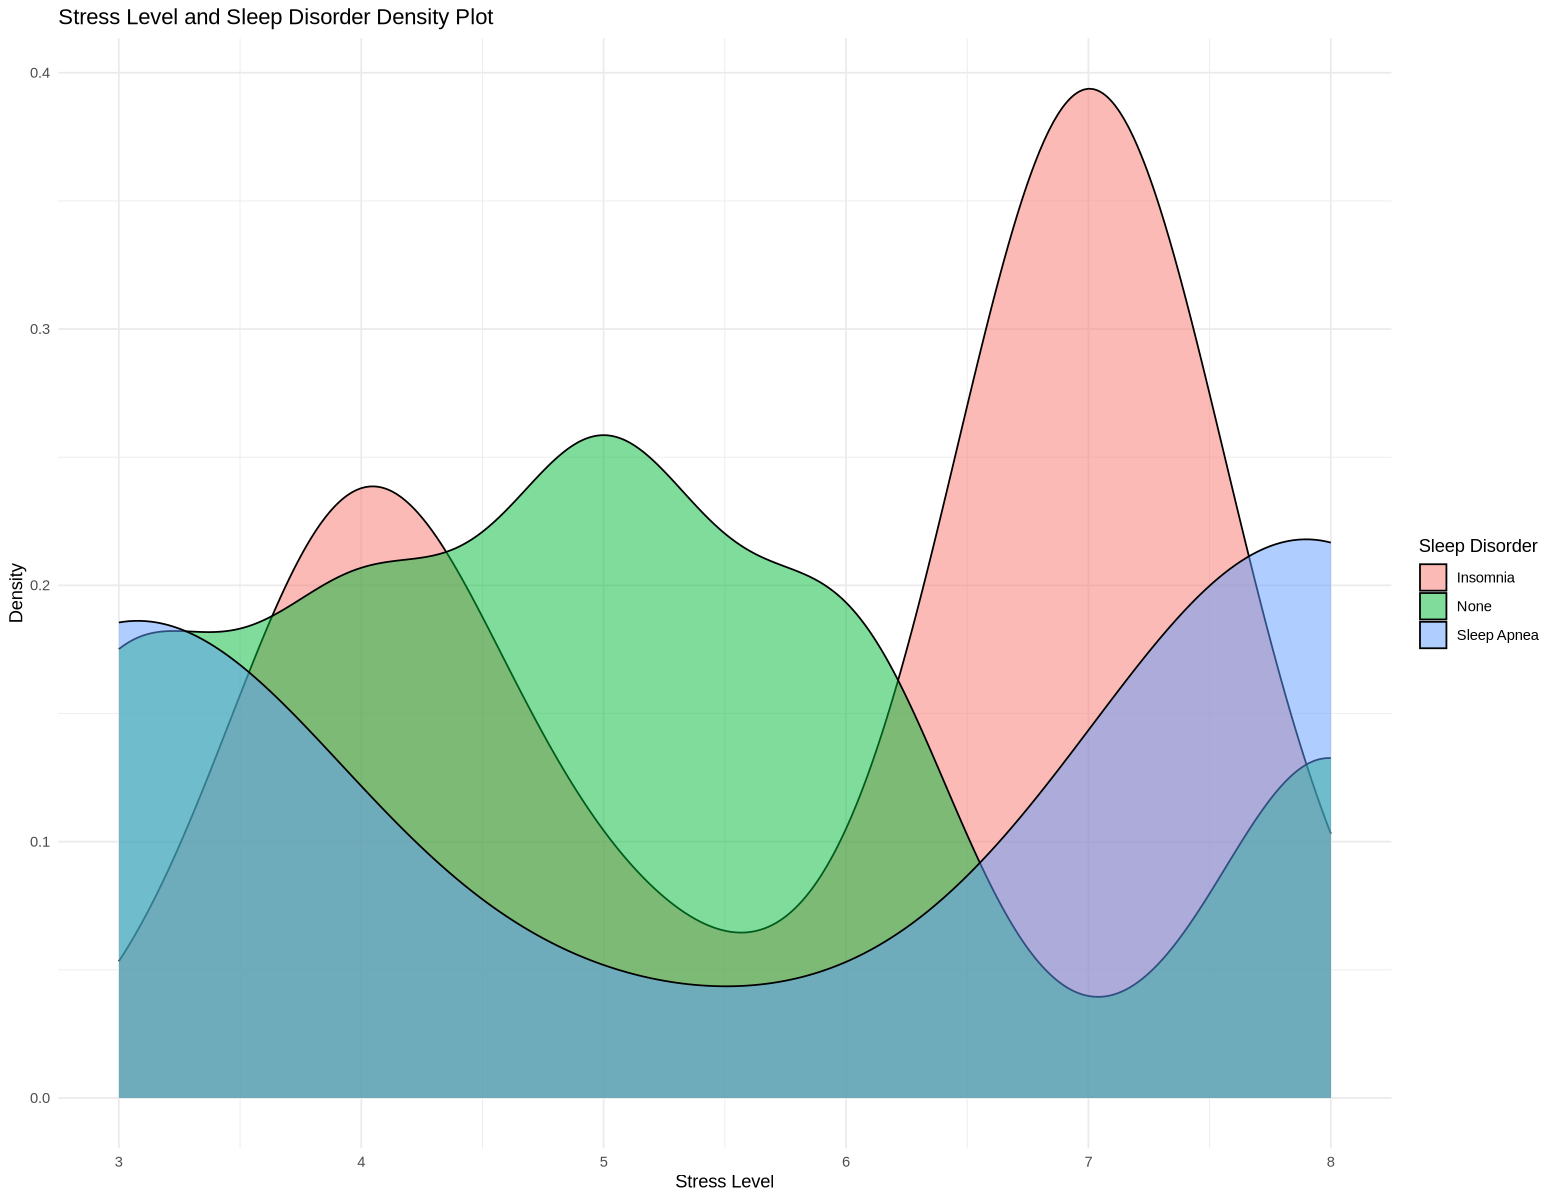

In [15]:
# Main developer: Yuki
# Density plot using stress_level and sleep_disorder
options(repr.plot.width = 13, repr.plot.height = 10)
density_plot <- sleep_data |>
ggplot(aes(x = stress_level, fill = sleep_disorder)) +
geom_density(alpha = 0.5) +
labs(title = "Stress Level and Sleep Disorder Density Plot", x = "Stress Level", y = "Density", fill = "Sleep Disorder") +
theme_minimal()

density_plot

Plot. 2

**Plot.2 Interpretation:** \
This density plot shows the distribution of stress levels across individuals with different sleep disorders. The group without sleep disorder records a lower stress level, which could have an association between the two variables. People with insomnia tend to report higher stress levels, peaking around 7, while those with no sleep disorder and sleep aphena are more evenly spread across moderate stress levels. 

This suggests a potential association between high stress and an insomnia diagnosis. However, since stress is a subjective self-reported rating, the data may be influenced by personal perception and lacks objective medical validation, which could affect the interpretation of this pattern.

Scribe: Yuki

#### Summary Table:

In [16]:
# Main developer: Yuki
# Summary table from vtable library
summary_table <- st(sleep_data, out = "return") |>
select(-N)
summary_table

Variable,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
person_id,188,108,1,94,281,374
gender,,,,,,
... Female,49%,,,,,
... Male,51%,,,,,
age,42,8.7,27,35,50,59
sleep_duration,7.1,0.8,5.8,6.4,7.8,8.5
quality_of_sleep,7.3,1.2,4,6,8,9
physical_activity_level,59,21,30,45,75,90
stress_level,5.4,1.8,3,4,7,8


**Summary Table Interpretation:** \
The summary table reveal several notable patterns in the dataset. On average, individuals sleep 7.1 hours per night, which aligns well with recommended guidelines, and they rate their sleep quality relatively high, with a mean score of 7.3 out of 10. However, stress levels show more variation, with a mean of 5.4 and a relatively high standard deviation, suggesting that stress perception differs significantly across individuals. Daily step count stands out as an area of concern, averaging 6,817 steps per day, which is below the commonly recommended 10,000 step goal, and varies widely between participants. Additionally, while 58% of individuals fall into the "Normal" BMI category, a substantial 40% are classified as overweight, 3% classified as obese indicating a potential area for health intervention. Importantly, 42% of individuals report having a sleep disorder (either insomnia or sleep apnea), highlighting the relevance of sleep related health issues in this population.

Scribe: Yuki 

### c) Methods: Plan (Using Lasso for Model shrinkage and variable selection) 

#### Logistic Regression model
We will be using Logistic Regression to create a prediction model for a binary variable(whether a person has a sleeping disorder or not). Since the target variable is binary, we will be using logistic regression.

#### LASSO

For model selection we will be using LASSO to simplify the model by selecting the variables by making some of the coefficients to 0. This has two effects: simplifying the model which will help us reduce the cost of creating the model as we will need limited amount of data required.  and generalizing the model by penalizing. Since Ridge can not eliminate any variable, it will be more affective to use LASSO. 
We are conducting a 10 crossfold validation as a method to choose the optimum lambda value. 
The model evaluation will be done using AUC and it will be visualized as well

Scribe: Masaya

#### Computational Code and Output

In [17]:
# Main developer: Yuki
# making sleep_disorder binary and dropping person_id
sleep_data_binomial <- sleep_data |>
mutate(sleep_disorder = if_else(sleep_disorder == "None", 0, 1)) 

head(sleep_data_binomial)

person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,systolic_bp,diastolic_bp,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,0
2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,0
3,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,0
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,1
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,1
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140,90,85,3000,1


In [18]:
# Main developer: Masaya
set.seed(20250411)

# Splitting the data set into two parts: Test and Train
sleep_disorder_train <- 
    sleep_data_binomial |>
    slice_sample(prop = 0.6) 

sleep_disorder_test <- 
    sleep_data_binomial |>
    anti_join(sleep_disorder_train, by = "person_id")

sleep_disorder_train <- 
    sleep_disorder_train |>
    select(-person_id)

sleep_disorder_test <- 
    sleep_disorder_test |>
    select(-person_id)


In [19]:
# Main developer: Masaya
# Creating model matrices to prepare for glmnet
model_matrix_X_train <- 
    model.matrix(sleep_disorder ~ . , data = sleep_disorder_train)[,-1]

matrix_Y_train <- 
    as.matrix(sleep_disorder_train$sleep_disorder, ncol = 1)

#### LASSO Logistic Regression 
Since we have already prepared the two matrices, we will find a value of lamda for largest AUC when lasso is applied. 

We will be using cross-validation choosing to fold 10 times.

In [20]:
# Main developer: Masaya
# Using glmnet to find the appropriate value of lambda
set.seed(1234)
sleep_disorder_cv_lambda_lasso <- 
    cv.glmnet(
        x = model_matrix_X_train,
        y = matrix_Y_train,
        alpha = 1, 
        family = "binomial",
        type.measure = "auc", 
        nfolds = 10)

sleep_disorder_cv_lambda_lasso


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.05087    22  0.9356 0.02411       8
1se 0.29793     3  0.9308 0.02445       2

#### Choosing Lambda Value

Given the result of cross validation, we have two lamda options to choose from. One is the ƛ = 0.02332 which will maximize the value of the AUC but will have more predictor values and less genralized. The Second option is to let ƛ = 0.26191 which will have only three selected predictor values and more generalized model. 

We will visualize this the AUC values on y axis and different lambda values on x axis

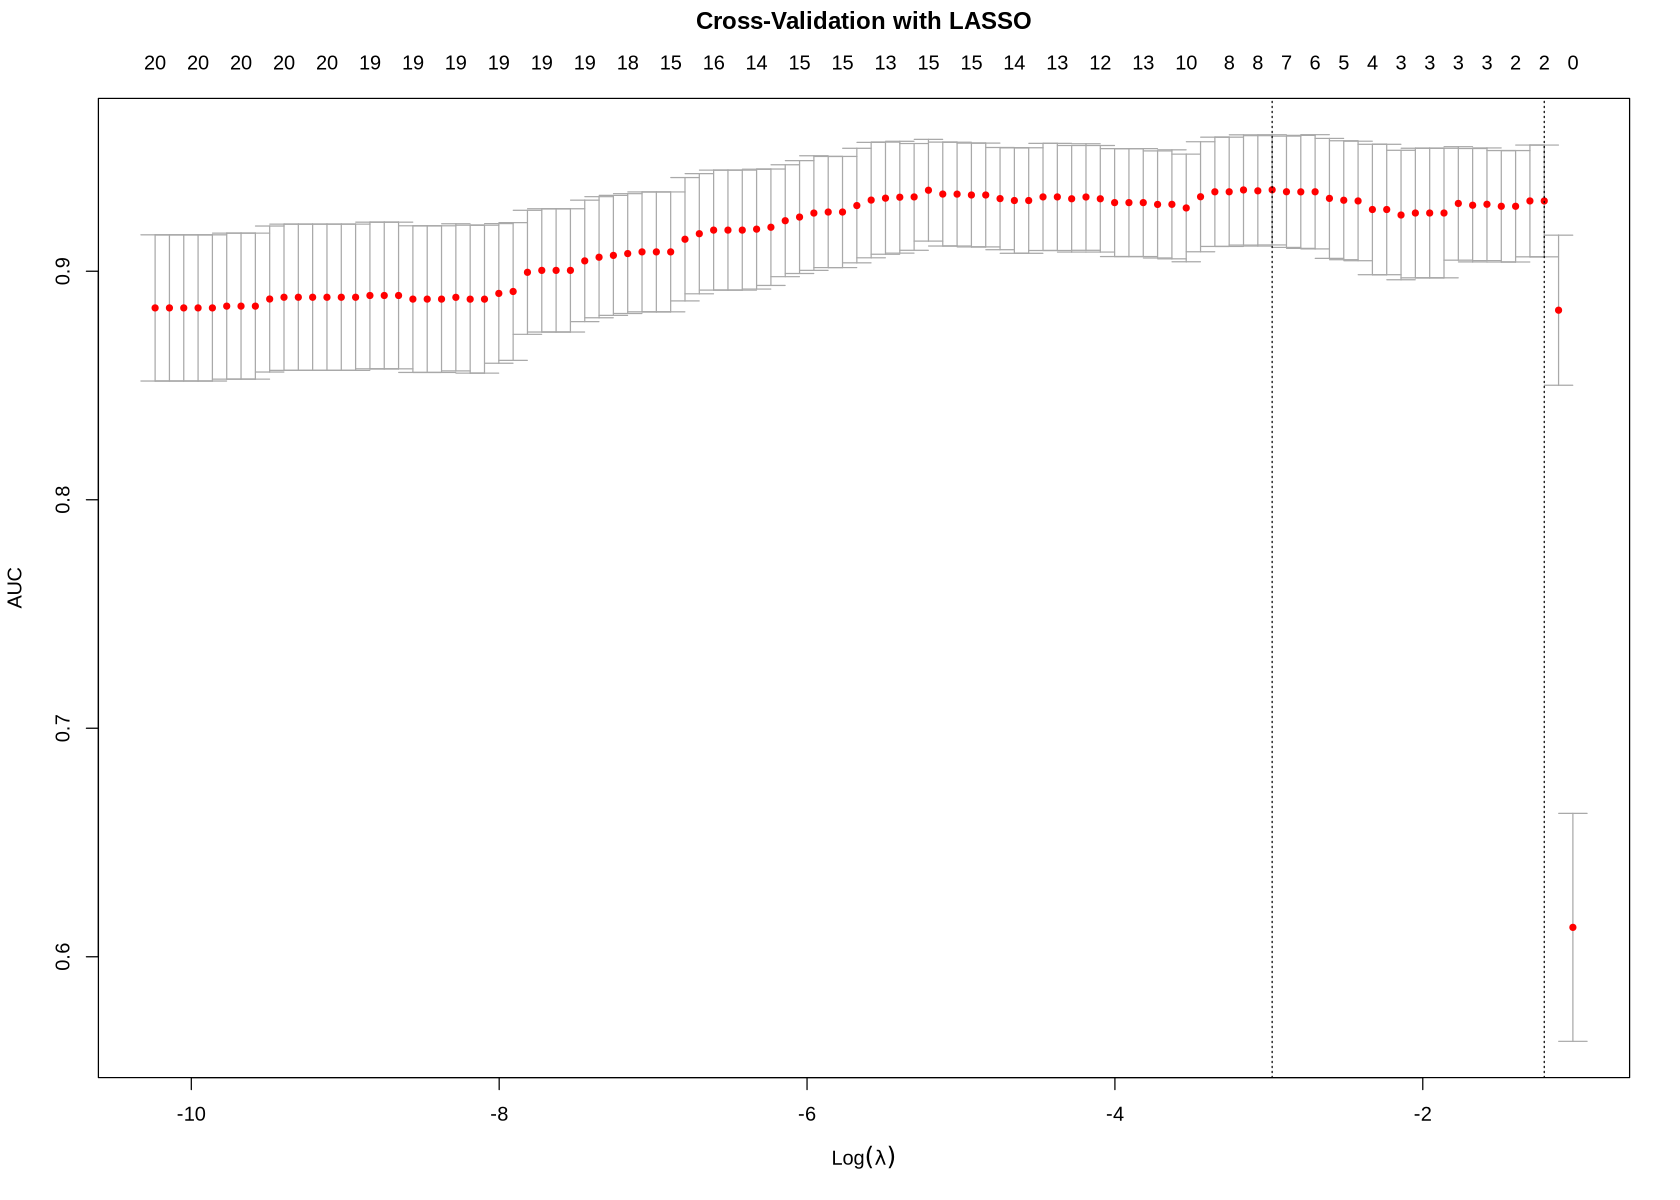

In [21]:
# Main developer: Masaya
options(repr.plot.width = 14, repr.plot.height = 10)
plot(sleep_disorder_cv_lambda_lasso , main = "Cross-Validation with LASSO\n\n")

In this case, we will choose to use the largest lamda with in 1 standard error since we want to create a generalized and simple model this time.

In [22]:
# Main developer: Masaya
# Choosing the 1SE lambda value
lambda_1se_AUC_LASSO <- round(sleep_disorder_cv_lambda_lasso$lambda.1se, 4)
lambda_1se_AUC_LASSO

[1] 0.2979

#### Creating the fitted LASSO model and 1SE lambda value

Now, given the lambda value, we will be fitting the lasso model and the coefficient values that are chosen given using the lasso shrinkage method. 

In [23]:
# Main developer: Masaya 
# Fitting the model using the 1SE lambda
set.seed(1234)

sleep_disorder_LASSO_1se_AUC <- glmnet(
    x = model_matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial", 
    lambda = lambda_1se_AUC_LASSO)

coef(sleep_disorder_LASSO_1se_AUC)

23 x 1 sparse Matrix of class "dgCMatrix"
                                         s0
(Intercept)                    -0.898939489
genderMale                      .          
age                             .          
occupationDoctor                .          
occupationEngineer              .          
occupationLawyer                .          
occupationManager               .          
occupationNurse                 .          
occupationSales Representative  .          
occupationSalesperson           .          
occupationScientist             .          
occupationSoftware Engineer     .          
occupationTeacher               .          
sleep_duration                  .          
quality_of_sleep                .          
physical_activity_level         .          
stress_level                    .          
bmi_categoryObese               .          
bmi_categoryOverweight          0.441154613
systolic_bp                     .          
diastolic_bp                    0.

### Selected Variables 

The LASSO model performed a variable selection by shrinking many coefficients to zero, and removing them from our logistic regression model. This means that only the most informative predictors were retained to improve model interpretability and prevent overfitting. In this case, out of all predictors, only two variables were selected: `bmi_categoryOverweight` and `diastolic_bp`. The positive coefficient for `bmi_categoryOverweight` (0.4412) suggests that individuals who are overweight have higher odds of having a sleep disorder compared to the reference group (those with normal BMI), while the coefficient for `diastolic_bp` (0.0062) indicates a slight positive association between higher diastolic blood pressure and the likelihood of sleep disorder. Interestingly, while `bmi_categoryOverweight` was selected, `bmi_categoryObese` was not selected by the model. This could be because LASSO tends to select only one variable from a group of categorical variable of correlated predictors, and in this dataset, the overweight category may have provided stronger or more distinct predictive power than the obese category. As there are only 3% of the individuals in the dataset that is classified as obese, seen in the summary table, it is also possible that the number of obese individuals in the dataset was too small to contribute significantly to the model. However, we have to keep in mind that coefficients are biased due to the LASSO variable selection. It does make sense intuitively that overweight people has a higher odd of getting sleep disorder. Thus we can conclude that it could be a good predicting model.

Scribe: Yuki

#### Testing the lasso model created using the test sets

Now we will use the test set to evaluate the quality of the model created. 

In [24]:
# Main developer: Masaya
# creating model matrix for test data set and using roc function for test
model_matrix_X_test <- 
    model.matrix(sleep_disorder ~ . , data = sleep_disorder_test)

predictor = predict(
    sleep_disorder_LASSO_1se_AUC,
    newx = model_matrix_X_test,
    s = "lambda.1se",
    type = "response")

ROC_lasso <- roc(
    response = sleep_disorder_test$sleep_disorder, 
    predictor = predictor)

ROC_lasso

Setting levels: control = 0, case = 1

Warning message in roc.default(response = sleep_disorder_test$sleep_disorder, predictor = predictor):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases




Call:
roc.default(response = sleep_disorder_test$sleep_disorder, predictor = predictor)

Data: predictor in 97 controls (sleep_disorder_test$sleep_disorder 0) < 53 cases (sleep_disorder_test$sleep_disorder 1).
Area under the curve: 0.9553

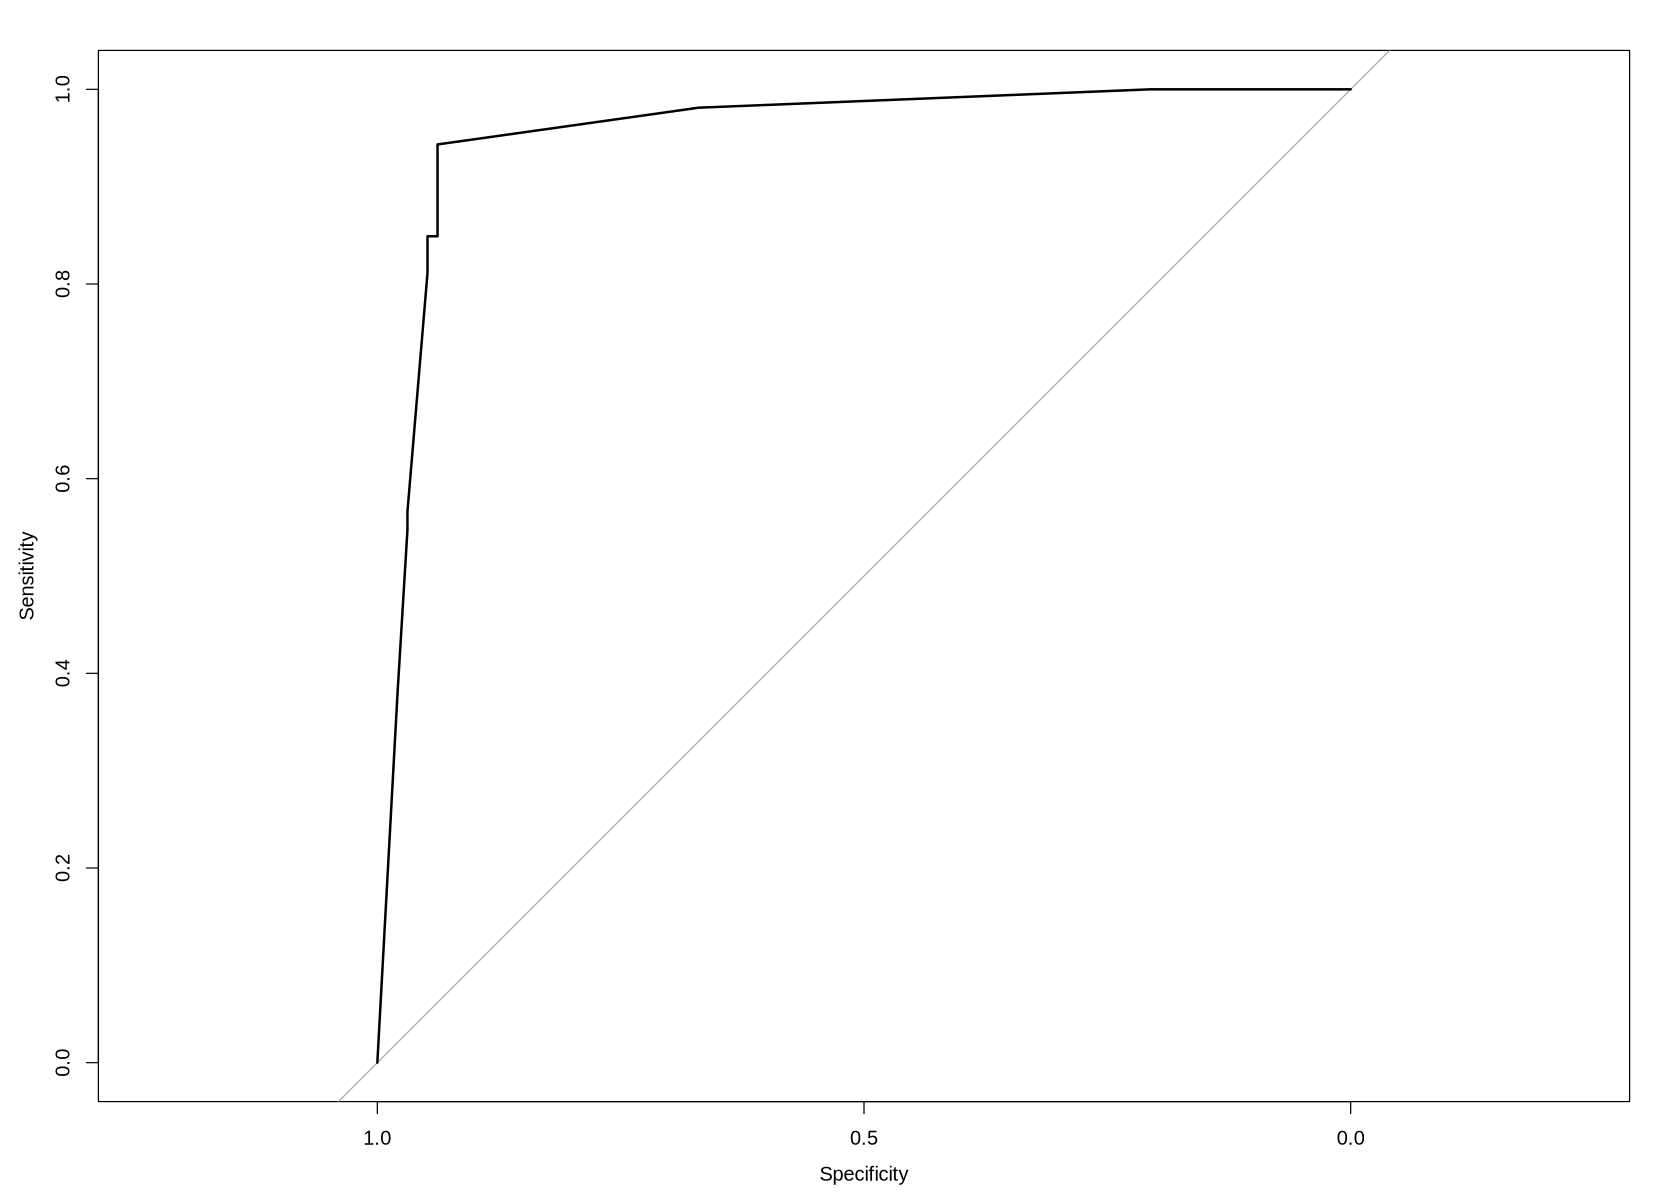

In [25]:
# Main developer: Masaya
# Plot the ROC curve for the lasso model
plot(ROC_lasso)

### Analysis 

To answer our question **"Can various health factors be used to determine whether or not someone has a sleep disorder?"**, the answer will be yes as we achieved 0.95 AUC and two variables were used. 


## Discussion

The final model selected only two predictors, `bmi_categoryOverweight` and `diastolic_bp`. This result is meaningful, since it highlights how individuals classified as overweight had significantly higher odds of having a sleep disorder, a result that is both intuitive and consistent with public health literature. Interestingly, LASSO excluded the obese category, possibly due to its smaller proportion in the dataset, with only 3% of the dataset, or due to multicollinearity between BMI categories. The diastolic blood pressure variable was also selected with a small positive coefficient, suggesting that even subtle differences in blood pressure could relate to sleep disorder risk. 

While we used LASSO with 10 fold cross validation and the 1 Standard Error rule to promote model simplicity and generalizability, alternative approaches could have been considered. For example, using the minimum cross validation error (lambda.min) or maximum AUC value would have resulted in a model with more predictors, possibly improving predictive power at the expense of interpretability. However, we chose to use the 1SE rule because it favors a more penalized model, which is less likely to overfit and easier to interpret, especially in a public health context. Ridge was not used for our variable selection method since they do not shrink the coefficients to zero, thus cannot drop the variables and simplify the model. 

Our model performed well on the test set, achieving an AUC of 0.9553, indicating high predictive accuracy. This strong result supports the idea that even a small number predictors can effectively identify individuals at risk of sleep disorders. 
The thing that came out as unexpected was that most health related variables, such as sleep duration, stress level, or physical activity level were not retained by LASSO. This may be due to correlations among variables, the relatively small sample size, or the model's tendency to prioritize parsimony. Additionally, coefficients from LASSO are known to be biased toward zero, which is a trade-off for reducing overfitting.

For future analysis, we could conduct an interaction analysis to see whether the effect of being overweight on sleep disorders is amplified or reduced by high diastolic blood pressure, especially since both are indicators of potential cardiovascular risk. Additionally, we could perform subgroup analysis, such as stratifying the dataset by age or gender, to see if the association between being overweight and sleep disorders holds across all demographics or is more pronounced in certain groups. 

Scribe: Yuki

## References

Grandner, M. A. (2017). *Sleep, health, and society*. Sleep Medicine Clinics, 12(1), 1–22. https://doi.org/10.1016/j.jsmc.2016.10.012 

Tharmalingam, L. (2023). *Sleep health and lifestyle dataset*. Kaggle. https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

Watson, N. F., Martin, J. L., Wise, M. S., Carden, K. A., & Curhan, G. C. (2015). *Delaying middle school and high school start times is a key factor in reducing adolescent sleep deprivation*. Journal of Clinical Sleep Medicine, 11(10), 1151–1154. https://doi.org/10.5664/jcsm.5020